<h2> Data PreProcessig  and Feature Engineering

In [78]:
import pandas as pd
import numpy as np
import os
import re
from matplotlib import pyplot as plt
os.chdir('C:/Users/Shashi Suman/Downloads/')

mod = pd.read_csv('SVC (4).csv')
print('Loading Data........')
train = pd.read_json('train.json')
test = pd.read_json('test.json')
train.fillna(0, inplace=True)
print('Data Loaded\n\nData Preprocessing.....')

def preprocess_2(data):
    from nltk.stem import WordNetLemmatizer
    import nltk
    df = data.copy()
    df['temp'] = df['ingredients'].apply(lambda x: str(x).replace('[','').replace(']',''))
    df['temp'] = df['temp'].apply(lambda x: [WordNetLemmatizer().lemmatize(re.sub('[^A-Za-z]','', val.strip())) for val in x.split(',')])
    df['temp'] = df['temp'].apply(lambda x: str(x).replace("-", " ").replace("&", " ").replace("'", " ").replace("''", " ").replace("%", " ").replace("!", " ").replace("(", " ").replace(")", " "))
    df['temp'] = df['temp'].apply(lambda x: str(x).replace("/", " ").replace("/", " ").replace(",", " ").replace(".", " ").replace(u"\u2122", " ").replace(u"\u00AE", " ").replace(u"\u2019", " ")) 
    df['temp'] = df['temp'].apply(lambda x: str(x).replace('[ ','').replace(']',' ').lower())
    #Backup Plan
    #df['temp'] = df['temp'].apply(lambda x: str(x).replace('activedryyeast','yeast').replace('aaipowder','aai'))
    if data.shape[1]==3:
        df.columns = ['id','cuisine','temp','ingredients']
        df['single'] = df['ingredients'].apply(lambda x: 1 if len(x.strip().split(' '))==1 else 0)
        bf = df[df.single != 1]
    else:
        df.columns = ['id','temp','ingredients']
        bf = df.copy()
    bf.reset_index(inplace=True, drop=True)
    return df, bf

df, bf = preprocess_2(train)
ef, gf = preprocess_2(test)

print('Preprocessing Complete')
print('Vectorization Started')
from sklearn.feature_extraction.text import TfidfVectorizer
tfid = TfidfVectorizer(binary=True, ngram_range = (1, 1))
main_tfid = tfid.fit_transform(bf['ingredients'])
submit_tfid = tfid.transform(gf['ingredients'])
print('TF-IDf Vectorizer \n',main_tfid.shape)
print(submit_tfid.shape)
print('Data Vectorizing Complete')

Loading Data........
Data Loaded

Data Preprocessing.....
Preprocessing Complete
Vectorization Started
TF-IDf Vectorizer 
 (39752, 6656)
(9944, 6656)
Hashing Vectorizer
 (39752, 1048576)
(9944, 1048576)
Data Vectorizing Complete


<h2> Grid Search CV for SGD Classifier </h2>

In [80]:
print('\n Running SGD Classifier GridSearch\n')
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
params = {'loss':['log','hinge'], 'penalty':['l2'], 'max_iter':[2000, 6000, 8000], 'eta0':[0.1, 0.2, 0.3], 'alpha':[0.000001, 0.00001, 0.0001], 'learning_rate':'adaptive'}
glf = GridSearchCV(SGDClassifier(), params, cv=10, verbose=1, n_jobs=-1)
import warnings
warnings.filterwarnings("ignore")

glf.fit(main_tfid, bf['cuisine'])
print('Best Parameter: ',glf.best_params_)
print('Best CV Score: %.4f'%(glf.best_score_))


 Running SGD Classifier GridSearch

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   36.9s remaining:   24.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   47.3s finished


Best Parameter:  {'alpha': 1e-06, 'eta0': 0.2, 'learning_rate': 'adaptive', 'loss': 'log', 'max_iter': 6000, 'penalty': 'l2'}
Best CV Score: 0.7905


<h2>SGD Classifier</h2>

In [82]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.multiclass import OneVsRestClassifier

SGD = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l2', alpha=0.000001, max_iter=6000, shuffle=True, learning_rate='adaptive', eta0=0.2))
SGD.fit(main_tfid, bf['cuisine'])

out = np.array(SGD.predict(submit_tfid))
new_out = pd.concat([test['id'], pd.DataFrame(out)], axis=1)
new_out.columns = ['id','cuisine']
new_out = new_out.sort_values(by=['id'])
new_out.reset_index(inplace=True, drop=True)
new_out.to_csv('SGD_Model.csv', index=False)
print('Model Test Complete\nSaving Test Output')

Model Test Complete
Saving Test Output


<h2> Grid Search for Logistic Regression </h2>

In [86]:
print('\n Running SGD Classifier GridSearch\n')
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
params = {'C':['4','4.5','5.5','6'], 'max_iter':[50, 100, 150], 'solver':['newton-cg','sag']}
glf = GridSearchCV(LogisticRegression(), params, cv=10, verbose=1, n_jobs=-1)
import warnings
warnings.filterwarnings("ignore")

glf.fit(main_tfid, bf['cuisine'])
print('Best Parameter: ',glf.best_params_)
print('Best CV Score: %.4f'%(glf.best_score_))


 Running SGD Classifier GridSearch

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  1.5min remaining:   59.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.8min finished


Best Parameter:  {'C': 5.5, 'max_iter': 100, 'solver': 'newton-cg'}
Best CV Score: 0.7871


<h2>Logistic Regression </h2>

In [88]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
log = LogisticRegression(C=5.5, max_iter=100, solver='newton-cg', fit_intercept=True, n_jobs=4, multi_class='ovr')
ovr = OneVsRestClassifier(log, n_jobs=4)
ovr.fit(main_tfid, bf['cuisine'])

out = np.array(ovr.predict(submit_tfid))
new_out = pd.concat([test['id'], pd.DataFrame(out)], axis=1)
new_out.columns = ['id','cuisine']
new_out = new_out.sort_values(by=['id'])
new_out.reset_index(inplace=True, drop=True)
new_out.to_csv('Logistic_Model.csv', index=False)
print('Model Test Complete\nSaving Test Output')

Model Test Complete
Saving Test Output


<h2>Grid Search for Support Vector Classifier </h2>

In [86]:
print('\n Running Support Vector Classifier GridSearch\n')
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
params = {'C':['90','100','120'], 'gamma':[0.8, 1, 1.2]}
glf = GridSearchCV(SVC(), params, cv=10, verbose=1, n_jobs=-1)
import warnings
warnings.filterwarnings("ignore")

glf.fit(main_tfid, bf['cuisine'])
print('Best Parameter: ',glf.best_params_)
print('Best CV Score: %.4f'%(glf.best_score_))


 Running SGD Classifier GridSearch

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  1.5min remaining:   59.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.8min finished


Best Parameter:  {'C': 5.5, 'max_iter': 100, 'solver': 'newton-cg'}
Best CV Score: 0.7871


<h2> Support Vector Classifier </h2>

In [84]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
svc = SVC(C=100, kernel='rbf', gamma=1, tol=0.001)
svc_ovr = OneVsRestClassifier(svc, n_jobs=1)
svc_ovr.fit(main_tfid, bf['cuisine'])

out = np.array(svc_ovr.predict(submit_tfid))
new_out = pd.concat([test['id'], pd.DataFrame(out)], axis=1)
new_out.columns = ['id','cuisine']
new_out = new_out.sort_values(by=['id'])
new_out.reset_index(inplace=True, drop=True)
new_out.to_csv('SVC_Model.csv', index=False)
print('Model Test Complete\nSaving Test Output')

Model Test Complete
Saving Test Output


<H2> Exploratory Data Analysis </h2>

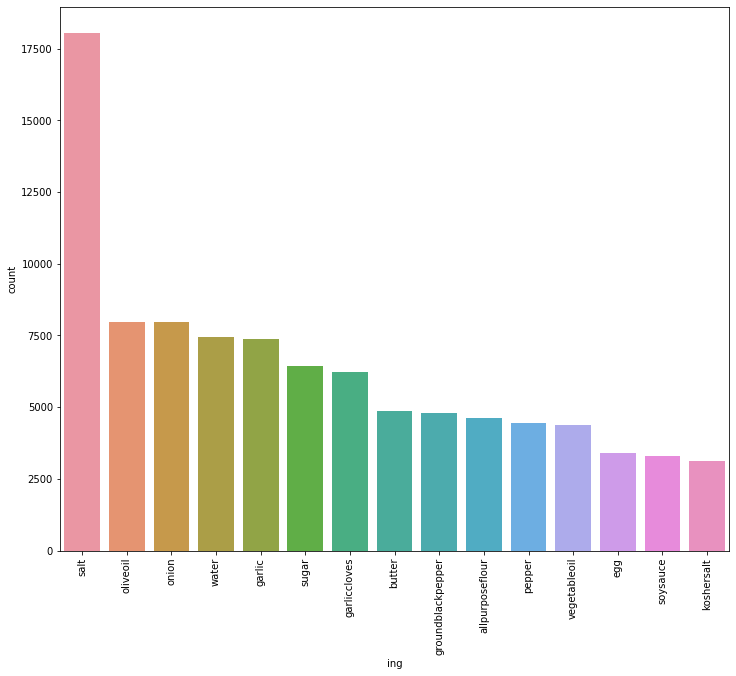

In [26]:
import seaborn as sns
fig, ax = plt.subplots()
fig.set_size_inches(12,10)
plt.xticks(rotation='vertical')
z = z.sort_values(by=['count'], ascending=False)
sns.catplot(x='ing', y='count', data=z.iloc[0:15, :], kind='bar', ax=ax)
plt.close(2)

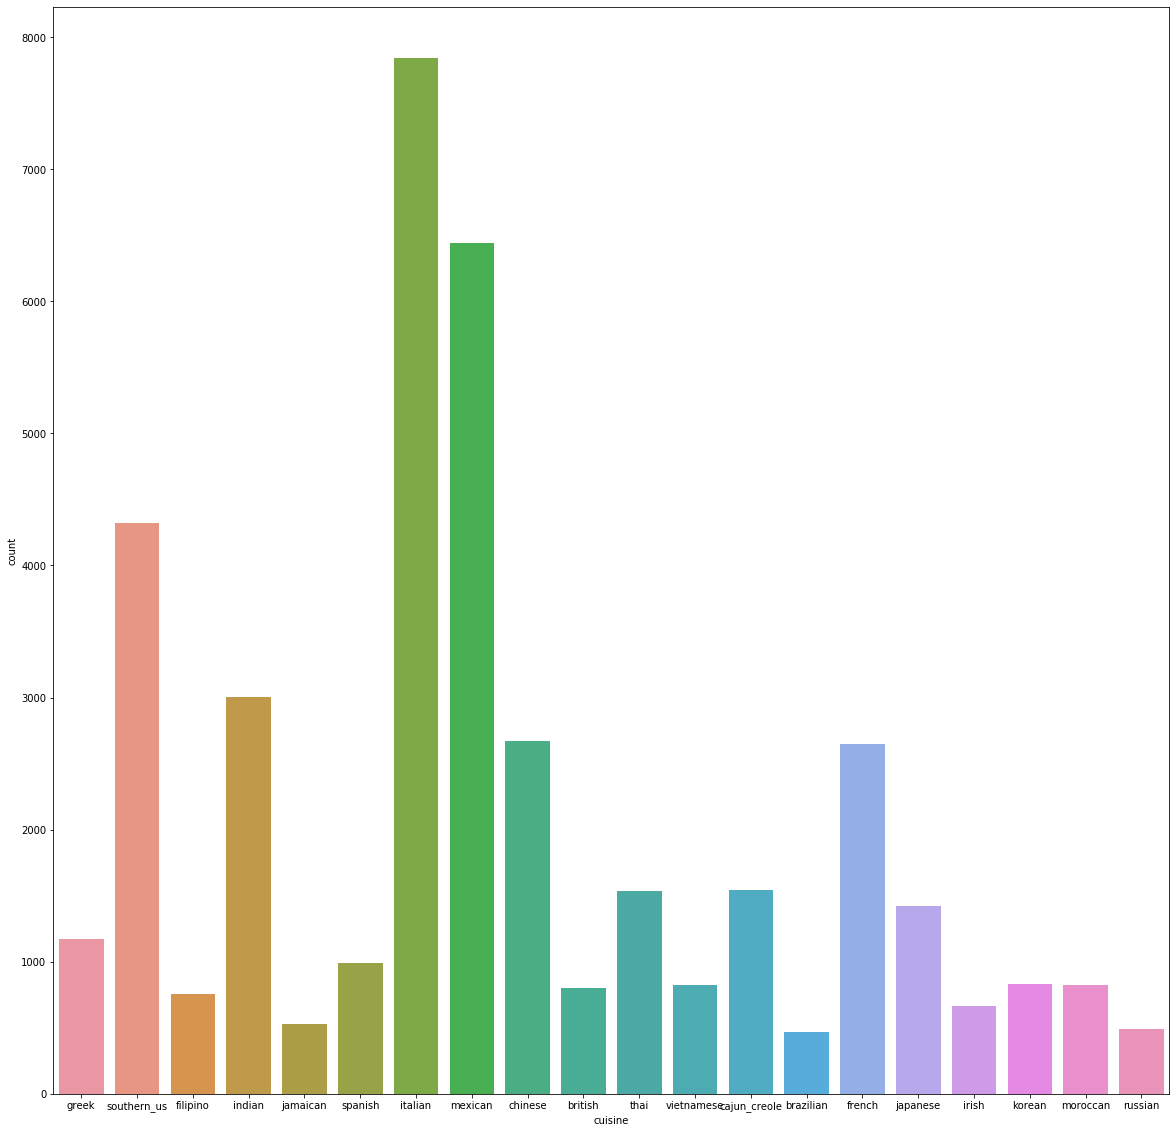

In [33]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 20)
sns.catplot(x='cuisine', kind='count', data=df, ax=ax)
fig.savefig('cuisine_count.png')
plt.close(2)

In [40]:
train_ing = []
for index, row in bf.iterrows():
    train_ing += row['ingredients'].strip().replace('  ',' ').split(' ')
crr = list(set(train_ing))
feature_train = np.zeros((bf.shape[0], len(crr)))
for index, row in bf.iterrows():
    krr = row['ingredients'].strip().replace('  ',' ').split(' ')
    for i in krr:
        feature_train[index, crr.index(i)] = 1
from sklearn.feature_extraction.text import TfidfTransformer
temp_tfid = TfidfTransformer()
feature_tfidf = temp_tfid.fit_transform(feature_train)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
red_main_tfid = pca.fit_transform(feature_tfidf.toarray())
pca2dataFrame = pd.DataFrame(red_main_tfid)
pca2dataFrame.columns = ['PC_1', 'PC_2']

In [ ]:
dat = pca2dataFrame.copy()
dat.astype(float)
dat = pd.concat([bf['cuisine'], dat], axis=1)

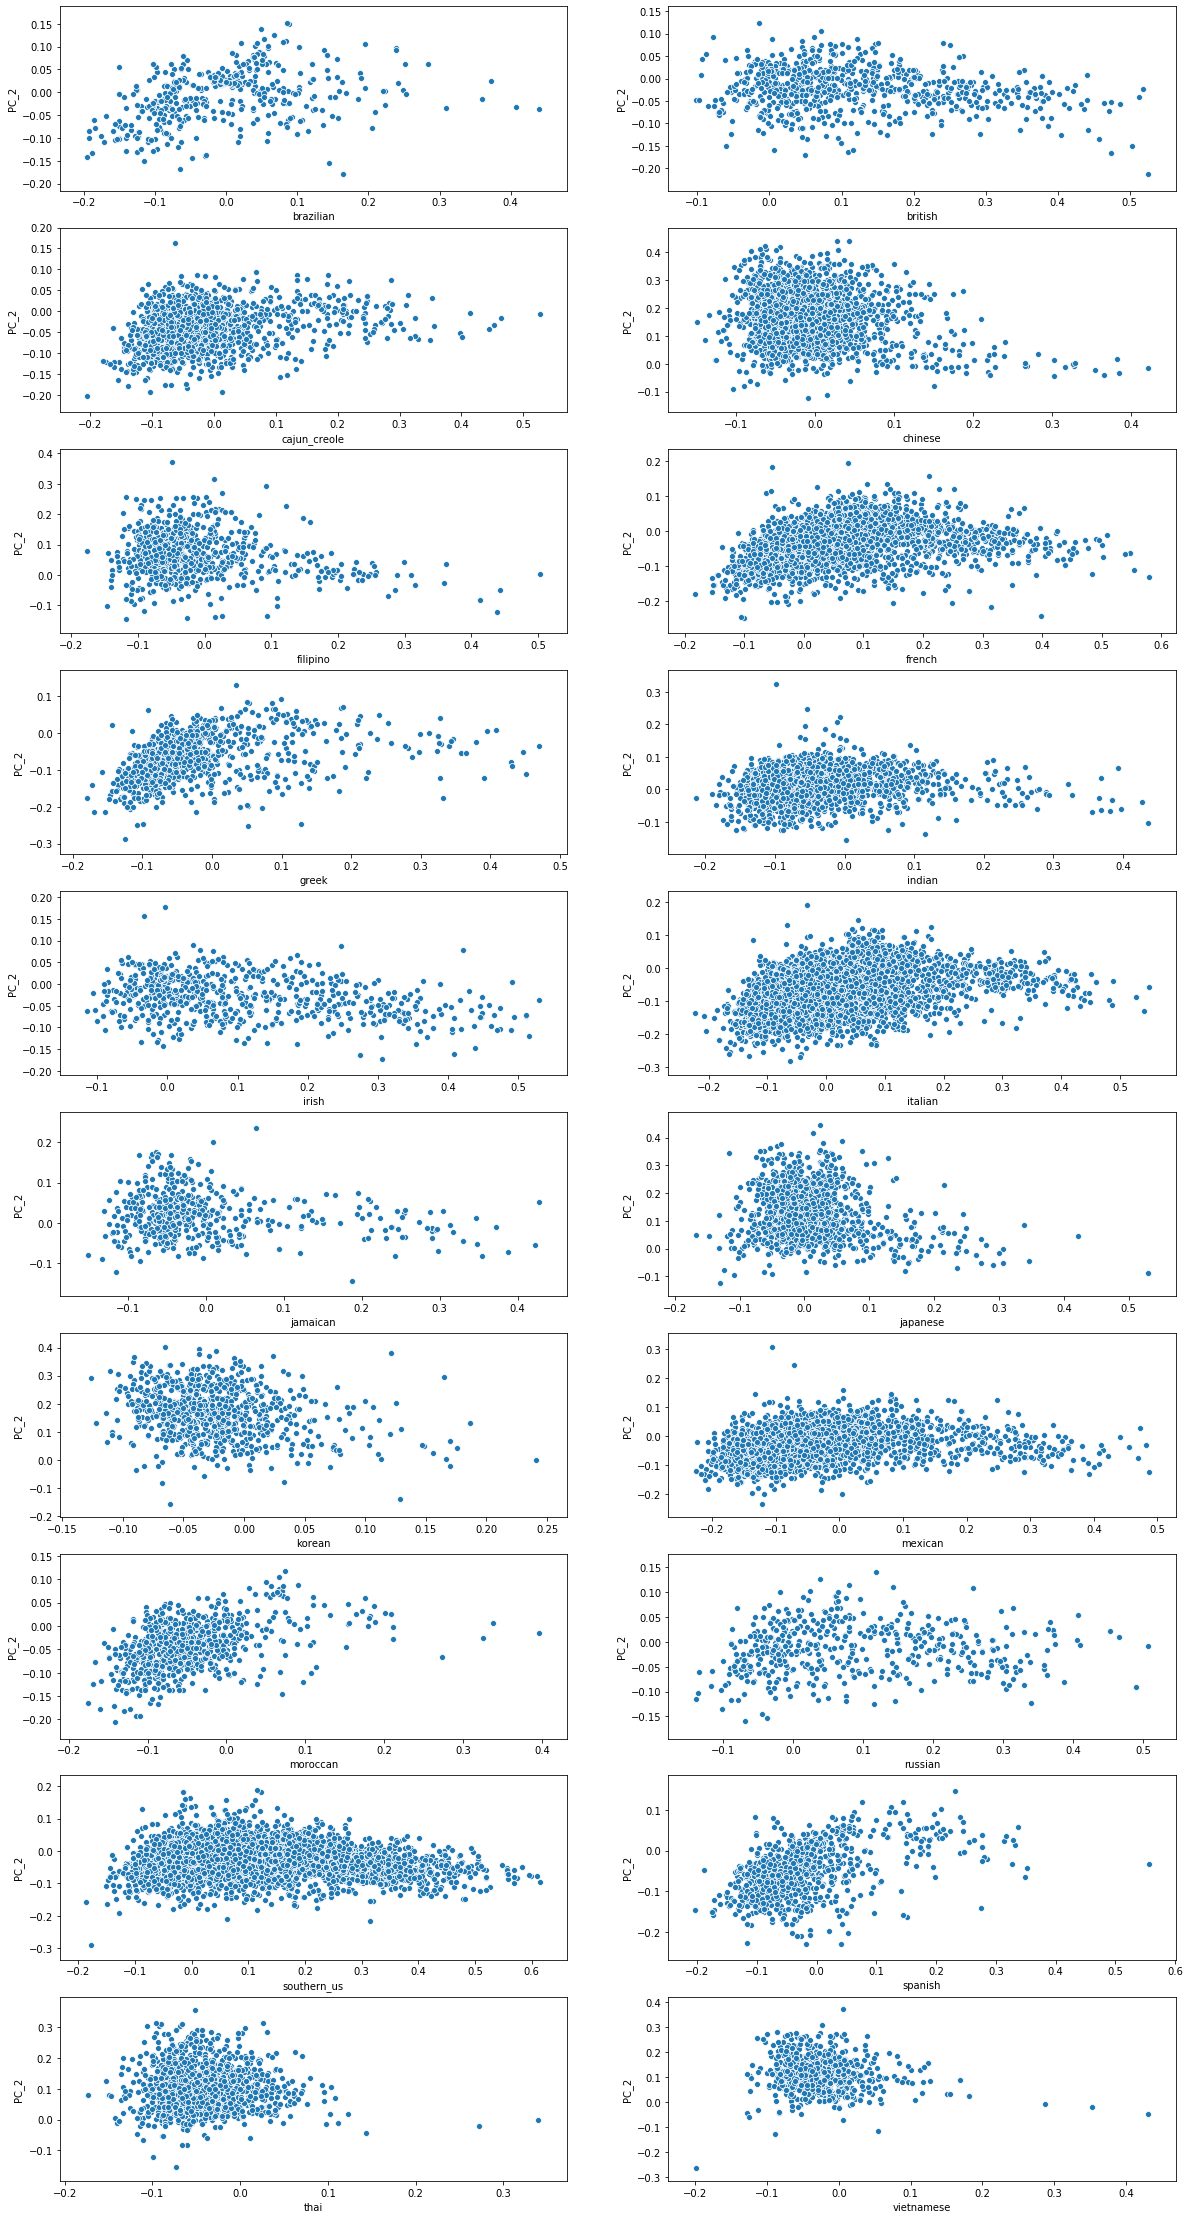

In [109]:
fig, ax = plt.subplots(nrows=10, ncols=2)
fig.set_size_inches(20, 40)
cnt = 0
col = 0
Y = pd.get_dummies(df['cuisine'])
for i in Y.columns:
    sns.scatterplot(x='PC_1', y='PC_2', data=dat[dat['cuisine']==i], ax = ax[np.floor(cnt).astype(int)][col])
    ax[np.floor(cnt).astype(int)][col].set(xlabel=i)
    cnt += 0.5
    if col==1:
        col=0
    else:
        col=1
fig.savefig('cuisine_plot.png')